In [35]:
import numpy as np
import cirq
from typing import Dict, Tuple
import matplotlib.pyplot as plt
from scipy.stats import logistic
import itertools as it
import pennylane as qml
from pennylane.optimize import AdamOptimizer
from ncon import ncon

    
from typing import List, Tuple, Any
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

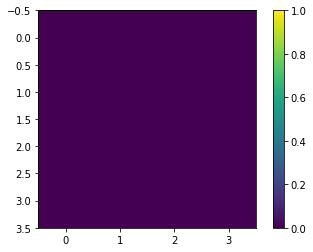

(12665, 4, 4, 1)
(12665, 16)
number of parameters  17
[0.57572082 0.84510275 0.52600219 0.77671848 1.02488174 0.66718932
 0.83360282 1.04229849 0.68175902 1.02155254]


In [36]:
# Binary neural network and dataset generation 

def sig(xx):
    return 1 / (1 +  np.exp(-xx))
def nonlinear(spin,xx):
    return np.where(np.reshape(spin,(1,-1,1))==1,sig(xx),np.maximum(xx,0))
    
def costfunction(samples,d_out,x,y):
    samplesi = np.copy(samples)
    samplesi = 2*samplesi-1
    d_in = x.shape[1]
    Ntrain = x.shape[0]
    
    c = d_in*d_out
    Ns = samples.shape[0]
    W1 = np.reshape(samplesi[:,0:c],[Ns,d_in,d_out])
    b_1 = np.reshape(samplesi[:,c:c+d_out],[Ns,d_out])

    # binary 

    p = sig(np.einsum('ij,kjl ->ikl',x,W1) + b_1) 
    Jw = -np.einsum('i,iwk ->wk', y,np.log(p))/Ntrain - np.einsum('i,iwk ->wk', 1-y,np.log(1-p))/Ntrain
    Jw = np.reshape(Jw,(-1))

    # multiclass
    #out = np.log(softmax(np.einsum('ij,kjl ->ikl',x,W1) + b_1, axis = 2))
    #Jw =  -np.einsum('ik,iwk ->w',y,out)/Ntrain


    #print(local_energies.shape)
    return  Jw

    

# ************* Data set MNIST *****************

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0


def filter_36(x, y):
#     keep = (y == 3) | (y == 6)
#     x, y = x[keep], y[keep]
#     y = y == 3
#     keep = (y == 0) | (y == 4)
#     x, y = x[keep], y[keep]
#     y = y == 0
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    y = y == 1
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

y_train = y_train.astype(int)
y_test = y_test.astype(int)



lx = 4
x_train_small = tf.image.resize(x_train, (lx,lx)) #.numpy()
x_test_small = tf.image.resize(x_test, (lx,lx)) #.numpy()



# x_train_small = tf.Session().run(x_train_small)
# x_test_small = tf.Session().run(x_test_small)

plt.imshow(x_train_small[10,:,:,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

print(x_train_small.shape)
x_train_small= np.reshape(x_train_small,(-1,lx*lx))
print(x_train_small.shape)
x_test_small= np.reshape(x_test_small,(-1,lx*lx))




# # converting labels to one hot vector
y_train_one_hot = np.zeros((y_train.size, y_train.max()+1))
y_train_one_hot[np.arange(y_train.size),y_train] = 1


y_test_one_hot = np.zeros((y_test.size, y_test.max()+1))
y_test_one_hot[np.arange(y_test.size),y_test] = 1




#****** Defining the logistic classifier  **************


d_out = 1 # dimension of output (10 for MNIST )
d_in = lx*lx  # Dimension of input 

#             W1          W2           b_2    b_1    Which nonlinear function 
#Nparameters = Nhid*d_in + Nhid*d_out + d_out+ Nhid + 1 

#logistic regression W1            b_1  
Nparameters =        d_out*d_in +  d_out

print("number of parameters ",Nparameters)


# Test function 

s = np.random.binomial(1, 0.5, (10,Nparameters))

cost = costfunction(s,d_out,x_train_small,y_train)
print(cost)



[0 0 0 0 0 0 0 0 0 0] [3.69297817]
[0.39037813] [-1  1 -1 -1  1 -1 -1 -1 -1  1]


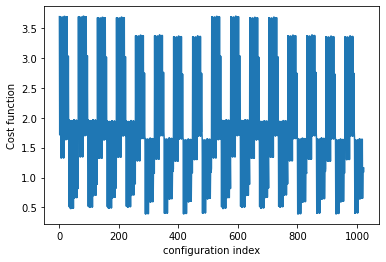

In [30]:
#*********** brute force finding the neural network with the lowest cost function **************
# all the possible "neural nets"
bits = (np.array(list(it.product(range(2), repeat = Nparameters )),dtype=np.int8))
a = (2*(np.array(list(it.product(range(2), repeat = Nparameters )),dtype=np.int8)) - 1)
#print(bits)

loss = costfunction(np.reshape(a[0],(1,-1)),d_out,x_train_small,y_train)
Weights = a[0]
print(bits[0],loss)
C = []
C.append(loss)

for i in range(1,a.shape[0]):
    #out = NN(a[i],Nhid,d_out,x) 
    #out = NN(a[i],Nhid,d_out,x)
    loss_new = costfunction( np.reshape(a[i],(1,-1)),d_out,x_train_small,y_train) 
    C.append(loss_new)
    #print(loss_new)
    #print(loss_new)
    if loss_new<loss:
        #print(loss,loss_new)  
        loss = loss_new
        Weights = a[i]

C = np.array(C)        
        

print(loss,Weights)
plt.plot(C)
plt.xlabel("configuration index")
plt.ylabel("Cost function")


np.savetxt("Cop_"+str(lx)+"x"+str(lx)+".txt",C)


In [31]:
# accuracy of classification 

def class_accuracy(samples,d_out,x,y):
    samplesi = np.copy(samples)
    samplesi = 2*samplesi-1
    d_in = x.shape[1]
    Ntrain = x.shape[0]
    
    c = d_in*d_out
    Ns = samples.shape[0]
    W1 = np.reshape(samplesi[:,0:c],[Ns,d_in,d_out])
    b_1 = np.reshape(samplesi[:,c:c+d_out],[Ns,d_out])

    # binary 

    p = sig(np.einsum('ij,kjl ->ikl',x,W1) + b_1)

    out = np.where(p >0.5, 1, 0)

    a = np.abs(np.transpose(p,[1,2,0])-y)
    
    acc = np.einsum('wki ->wk',(1 - a))/Ntrain 
    acc = np.reshape(acc,(-1))

    return  acc 

# testing the accuracy of a few solutions  and a random neural network

sols = Weights

random_nn = np.random.binomial(1,0.5,(1,Nparameters))

acc_test = class_accuracy(np.reshape(sols,(1,-1)),d_out,x_test_small,y_test)
acc_train = class_accuracy(np.reshape(sols,(1,-1)),d_out,x_train_small,y_train)
print(acc_test,acc_train,y_test.shape)

acc_test = class_accuracy(random_nn,d_out,x_test_small,y_test)
acc_train = class_accuracy(random_nn,d_out,x_train_small,y_train)
print(acc_test,acc_train,y_test.shape)


[0.71792636] [0.72016649] (2115,)
[0.61241546] [0.60514692] (2115,)


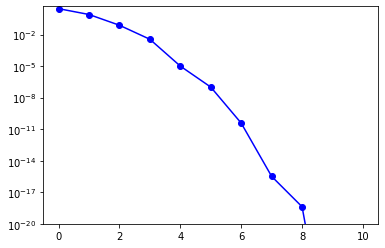

In [32]:
 # Basis
I = np.array([1, 1]);
Z = np.array([1,-1]); 
M = np.zeros((2,2))

M[0,:] = I
M[1,:] = Z 

N = Nparameters
psum = np.zeros((Nparameters*[2]))
d = 2
Ct = np.reshape(np.reshape(C,(-1)),d**N) 

for k in range(N):
    
    Ct = np.tensordot(M,Ct.reshape(d**k, d, d**(N - 1 - k)),axes=[[1], [1]]).transpose(1, 0, 2).reshape(d**N)



Ct = Ct/2**N

weight = np.zeros(Nparameters+1)

for k in range(2**N):
    
    indexw = np.sum(bits[k])
    weight[indexw] = weight[indexw] + Ct[k]**2


plt.yscale('log')
plt.plot(weight,'bo',ls='-')
plt.ylim((10**(-20),5))

np.savetxt("Ct_"+str(lx)+"x"+str(lx)+".txt",weight)
